In [145]:
# Import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Specify the path to CSV file
file_path = "C:/Users/Marco Plazzogna/Desktop/MAGISTRALE/PRIMO ANNO/PRIMO SEMESTRE/PYTHON FOR DS/Project/ml-latest/movies.csv"

# Use pandas read_csv function
movies = pd.read_csv(file_path, delimiter=',')

# Display the DataFrame
print(movies)

       movieId                                              title  \
0            1                                   Toy Story (1995)   
1            2                                     Jumanji (1995)   
2            3                            Grumpier Old Men (1995)   
3            4                           Waiting to Exhale (1995)   
4            5                 Father of the Bride Part II (1995)   
...        ...                                                ...   
86532   288967               State of Siege: Temple Attack (2021)   
86533   288971                                 Ouija Japan (2021)   
86534   288975   The Men Who Made the Movies: Howard Hawks (1973)   
86535   288977                    Skinford: Death Sentence (2023)   
86536   288983  UNZIPPED: An Autopsy of American Inequality (2...   

                                            genres  
0      Adventure|Animation|Children|Comedy|Fantasy  
1                       Adventure|Children|Fantasy  
2           

In [146]:
# Specify the path to CSV file
file_path = "C:/Users/Marco Plazzogna/Desktop/MAGISTRALE/PRIMO ANNO/PRIMO SEMESTRE/PYTHON FOR DS/Project/ml-latest/ratings.csv"

# Use pandas read_csv function
ratings = pd.read_csv(file_path,delimiter=',')

# Display the DataFrame
ratings = ratings.iloc[:, :-1] #eliminating the column for 'timestamp'
print(ratings)

# Convert the column to the desired data type
ratings['rating'] = ratings['rating']*2

ratings['rating'] = ratings['rating'].astype(np.int8)
print(ratings)

          userId  movieId  rating
0              1        1     4.0
1              1      110     4.0
2              1      158     4.0
3              1      260     4.5
4              1      356     5.0
...          ...      ...     ...
33832157  330975     8340     2.0
33832158  330975     8493     2.5
33832159  330975     8622     4.0
33832160  330975     8665     3.0
33832161  330975     8783     2.5

[33832162 rows x 3 columns]
          userId  movieId  rating
0              1        1       8
1              1      110       8
2              1      158       8
3              1      260       9
4              1      356      10
...          ...      ...     ...
33832157  330975     8340       4
33832158  330975     8493       5
33832159  330975     8622       8
33832160  330975     8665       6
33832161  330975     8783       5

[33832162 rows x 3 columns]


In [147]:
# Check if there are some not valid ratings
ratings = ratings[ratings['rating'] > 0]
ratings

,userId,movieId,rating
0,1,1,8
1,1,110,8
2,1,158,8
3,1,260,9
4,1,356,10
...,...,...,...
33832157,330975,8340,4
33832158,330975,8493,5
33832159,330975,8622,8
33832160,330975,8665,6


<BarContainer object of 10 artists>

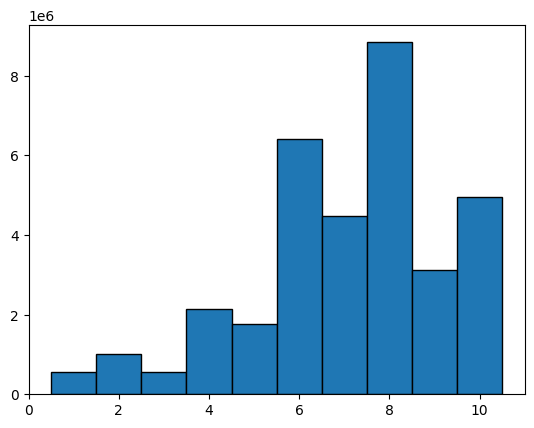

In [148]:
# Frequency of rating
u, c = np.unique(ratings['rating'].values, return_counts=True)
plt.bar(u, c, width=1, edgecolor='k')

In [149]:
def my_correlation(x, y):
    # Find indices where both x and y have non-zero values
    inds = np.where((x != 0) & (y != 0))[0]
    
    # Check if there are enough data points for correlation calculation
    if len(inds) > 1:
        # Calculate the correlation coefficient for the non-zero values
        return np.corrcoef(x[inds], y[inds])[0, 1]
    else:
        # Return -1 if there are not enough data points for correlation calculation
        return -1

In [150]:
class MovieRecommender:
    def __init__(self, rating, movie):
        # Initialize MovieRecommender object with user ratings and movie information
        self.rating = pd.DataFrame(rating)
        self.movie = pd.DataFrame(movie)

        # Count unique movie and user titles
        self.un_title, self.fr_title = np.unique(rating['movieId'], return_counts=True)
        self.un_users, self.fr_users = np.unique(rating['userId'], return_counts=True)
        
        # Create an empty rating matrix
        self.rating_matrix = self._create_rating_matrix()
        
        # Create a dictionary mapping movie IDs to movie titles
        self.dict = self._title_to_id_to_title()

    ##########################################################################################################################
    ### METHODS FOR MOVIE RECOMMENDATION ###
    ##########################################################################################################################

    def _create_rating_matrix(self):
        # Create a sparse rating matrix based on user ratings
        # The matrix is optimized for memory usage
        i = 1
        while (8 * len(self.un_users) * len(self.un_title)) * 1.073e-9 > 8: #minimum number of gb
            # Adjust user and movie counts based on rating frequency
            self.un_users = self.un_users[np.where(self.fr_users > i)[0]]
            self.fr_users = self.fr_users[np.where(self.fr_users > i)[0]]
            self.un_title = self.un_title[np.where(self.fr_title > i)[0]]
            self.fr_title = self.fr_title[np.where(self.fr_title > i)[0]]
            i += 1
        # Create and initialize the rating matrix
        self.rating_matrix = np.full((len(self.un_users), len(self.un_title)), 0)
        self.rating_matrix = self.rating_matrix.astype(np.int8)
        return self.rating_matrix

    def set_rating(self):
        # Set values in the rating matrix based on user ratings
        unique_id_to_index = {uid: i for i, uid in enumerate(self.un_users)}
        unique_title_to_index = {u_title: j for j, u_title in enumerate(self.un_title)}
        
        # Extract relevant information from ratings
        r = [unique_id_to_index[us] for us, tit in 
             zip(self.rating['userId'], self.rating['movieId']) if 
             (us in unique_id_to_index and tit in unique_title_to_index)]
        c = [unique_title_to_index[tit] for us, tit in 
             zip(self.rating['userId'], self.rating['movieId']) if 
             (us in unique_id_to_index and tit in unique_title_to_index)]
        v = [rat for us, tit, rat in 
             zip(self.rating['userId'], self.rating['movieId'], self.rating['rating']) if 
             (us in unique_id_to_index and tit in unique_title_to_index)]
        
        # Update the rating matrix
        self.rating_matrix[r, c] = v

    def get_rating_matrix(self):
        # Return the rating matrix as a Pandas DataFrame
        return pd.DataFrame(self.rating_matrix)
    
    def get_shape(self):
        # Return the shape of the rating matrix
        return self.rating_matrix.shape
    
    def plot_rating_matrix(self):
        # Plot the sparsity pattern of the rating matrix
        return plt.spy(self.rating_matrix, aspect='auto', markersize=0.005)
    
    def _title_to_id_to_title(self):
        # Create a dictionary mapping movie IDs to movie titles
        unique_title_to_index = {u_title: j for j, u_title in enumerate(self.un_title)}
        movie_title_dict = {id: tit for id, tit in zip(self.movie['movieId'],self.movie['title'])}
        self.dict = {key: value for key, value in movie_title_dict.items() if key in unique_title_to_index.keys()}
        return self.dict
    
    def get_name_movies(self):
        # Return a list of movie titles
        return self.dict.values()
    
    def __call__(self, movie_name):
        # Recommend movies based on the input movie name
        if movie_name in self.dict.values():
            id_num = list(self.dict.keys())[list(self.dict.values()).index(movie_name)]
        else:
            return f'The movie {movie_name} was not found'

        # Calculate movie recommendations based on user ratings
        x = self.rating_matrix[:, id_num]
        c = []
        for j in range(len(self.un_title)):
            corr = my_correlation(x, self.rating_matrix[:, j])
            if np.isnan(corr):
                c.append(np.nan)
            else:
                c.append(corr)
        
        c = np.array(c)
        ind_not_nan = np.where(~np.isnan(c))[0]
        ind_sorted = c[ind_not_nan].argsort()[::-1]
        ind_sorted = ind_not_nan[ind_sorted]

        # Extract movie suggestions based on correlation
        suggestion = [self.movie.iat[i,1] for i in ind_sorted[1:6]]

        # Plot the correlation values (limited to the first 1000)
        return suggestion, print(plt.plot(c[ind_sorted[0:1000]]))
    
##########################################################################################################################
### Class FOR GENRE RECOMMENDATION ###
##########################################################################################################################

class GenreRecommender:
    def __init__(self, rating, movie):
        # Initialize MovieRecommender object with user ratings and movie information
        self.rating = pd.DataFrame(rating)
        self.movie = pd.DataFrame(movie)

        # Count unique movie and user genres
        self.un_users, self.fr_users = np.unique(rating['userId'], return_counts=True)
        self.un_genre, self.fr_genre = np.unique(movie['genres'], return_counts=True) 
        
        # Create an empty rating matrix for genres instead of movie titles
        self.genre_matrix = self._create_genre_matrix() 
        
        # Create a dictionary mapping movie IDs to movie genres
        self.dict_genres = self._genres_to_id_to_genres()

        # New dataframe to work on
        # Merged dataframe with columns 'userId', 'movieId', 'rating', 'genres' (this one moved and adapted from self.movie dataset)
        self.new_rating = pd.concat([self.rating, pd.DataFrame(self._adapt_genres())], axis = 1) 
        self.new_rating.columns = ['userId', 'movieId', 'rating', 'genres'] 
        # New dataframe with computed means filtered with 'userId', 'genres'
        self.genre_mean = self.new_rating.groupby(['userId', 'genres'], as_index = False)['rating'].mean()
        self.genre_mean = pd.DataFrame(self.genre_mean)
    
    ##########################################################################################################################
    ### METHODS FOR GENRE RECOMMENDATION ###
    ##########################################################################################################################

    def _adapt_genres(self): 
        # Create a list (later changed to Pandas dataframe) of genres adapted to the the ratings dataset
        genres = []
        for i in self.rating['movieId']:
            if i not in self.dict_genres.keys():
                genres.append(0)
            genres.append(self.dict_genres[i])
        return pd.DataFrame(genres)
    
    def _create_genre_matrix(self): 
        # Create a sparse rating matrix based on user ratings and genre
        # The matrix is optimized for memory usage
        i = 1
        while (16 * len(self.un_users) * len(self.un_genre)) * 1.073e-9 > 8: #minimum number of gb
            # Adjust user based on rating frequency
            self.un_users = self.un_users[np.where(self.fr_users > i)[0]]
            self.fr_users = self.fr_users[np.where(self.fr_users > i)[0]]
            i += 1
        # Create and initialize the rating matrix
        self.genre_matrix = np.full((len(self.un_users), len(self.un_genre)), 0)
        self.genre_matrix = self.genre_matrix.astype(np.float16)
        return self.genre_matrix
    
    def _genres_to_id_to_genres(self): 
        # Create a dictionary mapping movie IDs to movie genres
        movie_genre_dict = {id: tit for id, tit in zip(self.movie['movieId'],self.movie['genres'])}
        return movie_genre_dict
    
    def set_rating_genres(self): 
        # Set values in the rating matrix based on user ratings
        unique_id_to_index = {uid: i for i, uid in enumerate(self.un_users)}
        unique_genre_to_index = {u_genre: j for j, u_genre in enumerate(self.un_genre)}
        
        # Extract relevant information from ratings
        r = [unique_id_to_index[us] for us, tit in 
             zip(self.genre_mean['userId'], self.genre_mean['genres']) if 
             (us in unique_id_to_index and tit in unique_genre_to_index)]
        c = [unique_genre_to_index[tit] for us, tit in 
             zip(self.genre_mean['userId'], self.genre_mean['genres']) if 
             (us in unique_id_to_index and tit in unique_genre_to_index)]
        v = [rat for us, tit, rat in 
             zip(self.genre_mean['userId'], self.genre_mean['genres'], self.genre_mean['rating']) if 
             (us in unique_id_to_index and tit in unique_genre_to_index)]
        
        # Update the rating matrix
        self.genre_matrix[r, c] = v

    def get_genre_matrix(self):
        # Return the rating matrix as a Pandas DataFrame
        return pd.DataFrame(self.genre_matrix)
    
    def get_shape_genre(self):
        # Return the shape of the rating matrix
        return self.genre_matrix.shape
    
    def plot_genre_matrix(self):
        # Plot the sparsity pattern of the rating matrix
        return plt.spy(self.genre_matrix, aspect='auto', markersize=0.005)
    
    def get_name_genres(self):
        # Return a list of genres
        return self.dict_genres.values()
    
    def __call_genre__(self, genre_name):
        # Recommend genres based on the input genre name
        if genre_name in self.dict_genres.values():
            id_num = list(self.dict_genres.keys())[list(self.dict_genres.values()).index(genre_name)]
        else:
            return f'The genre {genre_name} was not found'

        # Calculate movie recommendations based on user ratings
        x = self.genre_matrix[:, id_num]
        c = []
        for j in range(len(self.un_genre)):
            corr = my_correlation(x, self.genre_matrix[:, j])
            if np.isnan(corr):
                c.append(np.nan)
            else:
                c.append(corr)
        
        c = np.array(c)
        ind_not_nan = np.where(~np.isnan(c))[0]
        ind_sorted = c[ind_not_nan].argsort()[::-1]
        ind_sorted = ind_not_nan[ind_sorted]

        # Extract genre suggestions based on correlation
        suggestion = [self.dict_genres[i] for i in ind_sorted[1:6]]

        # Plot the correlation values (limited to the first 1000)
        return suggestion, print(plt.plot(c[ind_sorted[0:1000]]))

In [151]:
# Test section 1

# Creating a MovieRecommender object with user ratings and movie information
recommender = MovieRecommender(rating=ratings, movie=movies)

# Setting the rating matrix based on user ratings
print(recommender.set_rating())

# Getting the shape of the rating matrix
print(recommender.get_shape())

# Getting the complete rating matrix as a Pandas DataFrame
print(recommender.get_rating_matrix())

# Getting a list of movie titles in the dataset
print(recommender.get_name_movies())

None
(77376, 11999)
       0      1      2      3      4      5      6      7      8      9      \
0          8      0      6      0      0      0      0      0      0      0   
1          0      8     10      0      6      8      0      0      0      8   
2          6      0      0      0      0      0      0      0      0      0   
3          5      5      0      0      0      0      0      0      0      9   
4          6      6      0      0      0      0      0      0      0      7   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
77371      8      5      0      0      0     10      0      0      0      0   
77372      0      0      0      0      0      9      0      0      0      6   
77373      6      0     10      0      8      8      8      0      0      8   
77374      0      6      0      0      0      0      0      0      0      5   
77375      5      4      2      0      2      6      5      0      0      3   

       ...  11989  11990  11991

(["Big Girls Don't Cry (Große Mädchen weinen nicht) (2002)", 'SherryBaby (2006)', 'In-Laws, The (1979)', 'Wog Boy, The (2000)', 'Pursuit of Happyness, The (2006)'], None)


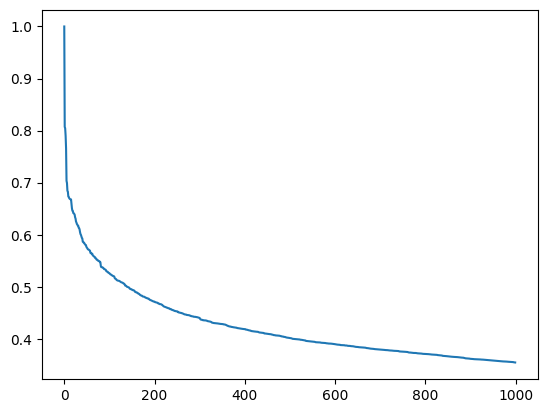

In [152]:
# Test section 2 with the movie 'Sudden Death (1995)'

print(recommender.__call__('Sudden Death (1995)'))

In [153]:
# Test section 3 with the movie 'Sudden Death'

print(recommender.__call__('Sudden Death'))

The movie Sudden Death was not found


c:\Users\Marco Plazzogna\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Marco Plazzogna\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


(['Wasp Woman, The (1959)', 'Lila Says (Lila dit ça) (2004)', 'Seaside (Bord de Mer) (2002)', 'Silk (2007)', 'I Hired a Contract Killer (1990)'], None)


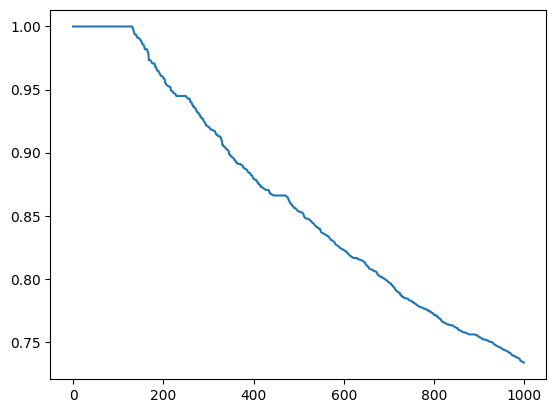

In [154]:
# Test section 4 with the movie 'Heartbreak Kid, The (1972)'

print(recommender.__call__('Heartbreak Kid, The (1972)'))

Line2D(_child0)


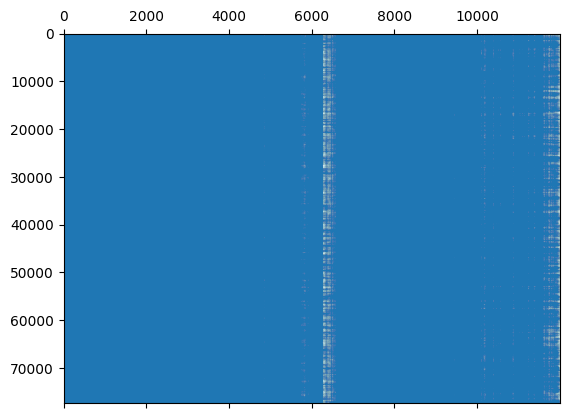

In [160]:
# Test section 5: plotting the rating matrix

print(recommender.plot_rating_matrix())

In [156]:
# Test section 1

# Creating a GenreRecommender object with user ratings and movie information
recommender2 = GenreRecommender(rating=ratings,movie=movies)

# Setting the rating matrix based on user ratings
print(recommender2.set_rating_genres())

# Getting the shape of the rating matrix
print(recommender2.get_shape_genre())

# Getting the complete rating matrix as a Pandas DataFrame
print(recommender2.get_genre_matrix())

None
(258438, 1796)
        0     1          2     3     4     5     6     7     8     9     ...  \
0        0.0   0.0   8.000000   0.0   0.0   9.0   0.0   0.0   0.0   0.0  ...   
1        0.0   6.0   0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2        0.0   0.0   0.000000   0.0   0.0  10.0   0.0   0.0   0.0   0.0  ...   
3        0.0   0.0   0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4        0.0   0.0   0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
...      ...   ...        ...   ...   ...   ...   ...   ...   ...   ...  ...   
258433   0.0   0.0  10.000000   0.0   0.0  10.0   0.0   0.0   0.0   0.0  ...   
258434   0.0   0.0   0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
258435   0.0   0.0   0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
258436   0.0   0.0   7.000000   0.0   0.0   6.0   0.0   0.0   0.0   0.0  ...   
258437   0.0   1.0   4.667969   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

        1786  1787 

Line2D(_child0)


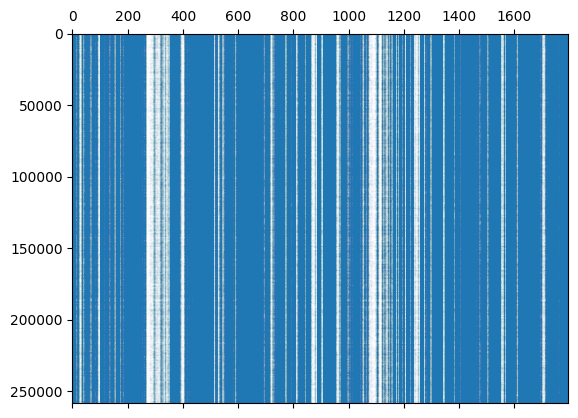

In [157]:
# Test section 2: plotting the rating matrix

print(recommender2.plot_genre_matrix())

In [158]:
# Test section 3: getting a list of genres in the dataset

print(recommender2.get_name_genres())

dict_values(['Adventure|Animation|Children|Comedy|Fantasy', 'Adventure|Children|Fantasy', 'Comedy|Romance', 'Comedy|Drama|Romance', 'Comedy', 'Action|Crime|Thriller', 'Comedy|Romance', 'Adventure|Children', 'Action', 'Action|Adventure|Thriller', 'Comedy|Drama|Romance', 'Comedy|Horror', 'Adventure|Animation|Children', 'Drama', 'Action|Adventure|Romance', 'Crime|Drama', 'Drama|Romance', 'Comedy', 'Comedy', 'Action|Comedy|Crime|Drama|Thriller', 'Comedy|Crime|Thriller', 'Crime|Drama|Horror|Mystery|Thriller', 'Action|Crime|Thriller', 'Drama|Sci-Fi', 'Drama|Romance', 'Drama', 'Children|Drama', 'Drama|Romance', 'Adventure|Drama|Fantasy|Mystery|Sci-Fi', 'Crime|Drama', 'Drama', 'Mystery|Sci-Fi|Thriller', 'Adventure|Romance|IMAX', 'Children|Drama', 'Drama|Romance', 'Crime|Drama', 'Documentary|IMAX', 'Children|Comedy', 'Comedy|Romance', 'Drama', 'Drama|War', 'Action|Crime|Drama', 'Drama', 'Action|Adventure|Fantasy', 'Comedy|Drama|Thriller', 'Drama|Romance', 'Mystery|Thriller', 'Animation|Children

(['Comedy', 'Drama|Musical', 'Drama', 'Action|Adventure', 'Comedy|Drama'], None)


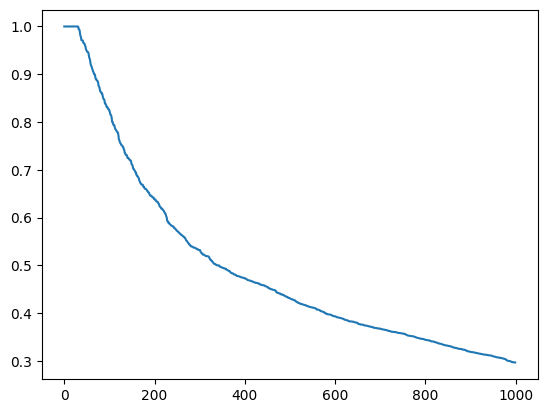

In [161]:
# Test section 4 with the genre 'Comedy|Romance'

print(recommender2.__call_genre__('Comedy|Romance'))